In [1]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2
%matplotlib inline

In [2]:
import os, sys, json, glob, collections, time

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask
import dask.distributed 

import large_image

import histomicstk as htk
import histomicstk.preprocessing.color_normalization as htk_cnorm
import histomicstk.preprocessing.color_deconvolution as htk_cdeconv
import histomicstk.features as htk_features
import histomicstk.utils as htk_utils
import histomicstk.segmentation.nuclear as htk_nuclear
import histomicstk.segmentation.label as htk_seg_label
import histomicstk.filters.shape as htk_shape_filters

from skimage.filters import threshold_yen, threshold_otsu, threshold_isodata
import skimage.morphology
from skimage.color import label2rgb

import logging
logging.basicConfig(level=logging.CRITICAL)

sys.path.append(os.path.normpath('/home/deepak.chittajallu/emory/code/HistomicsTK/server'))
from cli_common import utils as cli_utils  # noqa

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['axes.grid'] = True
plt.gray()

INFO:root:Created LRU Cache for 'tilesource' with 671 maximum size
INFO:root:Notice: Could not import MapnikTileSource


<Figure size 1080x1080 with 0 Axes>

### Define functions

In [14]:
def detect_nuclei_kofahi_log(im_nuclei_seg_input, im_nuclei_fgnd_mask, min_radius,
                             max_radius, min_nucleus_area, local_max_search_radius, debug=False):
    
    # smooth foreground mask with closing and opening
    im_nuclei_fgnd_mask = skimage.morphology.closing(
        im_nuclei_fgnd_mask, skimage.morphology.disk(3))

    im_nuclei_fgnd_mask = skimage.morphology.opening(
        im_nuclei_fgnd_mask, skimage.morphology.disk(3))

    im_nuclei_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_fgnd_mask)

    if debug:
        
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(im_nuclei_seg_input)

        plt.subplot(1, 2, 2)
        plt.imshow(im_nuclei_fgnd_mask)
    
    # run adaptive multi-scale LoG filter
    im_log_max, im_sigma_max = htk_shape_filters.cdog(
        im_nuclei_seg_input, im_nuclei_fgnd_mask,
        sigma_min=min_radius / np.sqrt(2),
        sigma_max=max_radius / np.sqrt(2)
    )

    # apply local maximum clustering
    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_nuclei_fgnd_mask, local_max_search_radius)

    # split any objects with disconnected fragments
    im_nuclei_seg_mask = htk.segmentation.label.split(im_nuclei_seg_mask, conn=8)

    # filter out small objects
    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

    if debug:
        
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(im_log_max)

        plt.subplot(1, 2, 2)
        plt.imshow(im_nuclei_seg_mask)
    
    return im_nuclei_seg_mask

def compute_tile_nuclei_features(slide_path, tile_position, args, it_kwargs,
                                 src_mu_lab=None, src_sigma_lab=None, debug=False):

    # get slide tile source
    ts = large_image.getTileSource(slide_path)

    # get requested tile"
    tile_info = ts.getSingleTile(
        tile_position=tile_position,
        format=large_image.tilesource.TILE_FORMAT_NUMPY,
        **it_kwargs)
    
    # get tile image
    im_tile = tile_info['tile'][:, :, :3]

    # perform color normalization
    im_nmzd = htk_cnorm.reinhard(
        im_tile,
        args.reference_mu_lab,
        args.reference_std_lab,
        src_mu=src_mu_lab,
        src_sigma=src_sigma_lab
    )

    # perform color decovolution
    if args.deconv_method == 'ruifrok':
        
        w = cli_utils.get_stain_matrix(args)
        im_stains = htk_cdeconv.color_deconvolution(im_nmzd, w).Stains.astype(np.float)[:, :, :2]

    elif args.deconv_method == 'macenko':
        
        w_est = htk_cdeconv.rgb_separate_stains_macenko_pca(im_tile, 255)
        im_stains = htk_cdeconv.color_deconvolution(im_tile, w_est, 255).Stains.astype(np.float)
        ch1 = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map[args.stain_1], w_est)
        ch2 = htk_cdeconv.find_stain_index(htk_cdeconv.stain_color_map[args.stain_2], w_est)
        im_stains = im_stains[:, :, [ch1, ch2]]
        
    else:
        
        raise ValueError('Invalid deconvolution method parameter.')

    if debug:
        
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(im_nmzd)
        plt.title('Normalized')

        plt.subplot(1, 3, 2)
        plt.imshow(im_stains[:, :, 0])
        plt.title('Hematoxylin')

        plt.subplot(1, 3, 3)
        plt.imshow(im_stains[:, :, 1])
        plt.title('Dab')
    
    # compute nuclear foreground mask
    im_fgnd_mask_stain_1 = im_stains[:, :, 0] < threshold_yen(im_stains[:, :, 1])
    im_fgnd_mask_stain_2 = im_stains[:, :, 0] < threshold_yen(im_stains[:, :, 1])
    im_fgnd_seg_mask = im_fgnd_mask_stain_1 | im_fgnd_mask_stain_2
    
    # segment nuclei
    im_nuc_seg_input = np.squeeze(np.min(im_stains[:, :, :2], axis=2))
    
    im_nuclei_seg_mask = detect_nuclei_kofahi_log( 
        im_nuc_seg_input,
        im_fgnd_seg_mask,
        args.min_radius,
        args.max_radius,
        args.min_nucleus_area,
        args.local_max_search_radius,
        debug=debug
    )
    
    # ignore border nuclei
    if args.ignore_border_nuclei is True:
        im_nuclei_seg_mask = htk_seg_label.delete_border(im_nuclei_seg_mask)
        
    if debug:
        
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(im_tile)

        plt.subplot(1, 2, 2)
        plt.imshow(label2rgb(im_nuclei_seg_mask, im_tile, bg_label=0))
        
    # generate nuclei annotations
    nuclei_annot_list = cli_utils.create_tile_nuclei_annotations(
        im_nuclei_seg_mask, tile_info, args.nuclei_annotation_format)

    # compute nuclei features
    stain_names = [args.stain_1, args.stain_2]

    fdata = [None]*2
    
    for i in range(2):
        
        fdata[i] = htk_features.compute_nuclei_features(
            im_nuclei_seg_mask, im_stains[:, :, i],
            fsd_bnd_pts=args.fsd_bnd_pts,
            fsd_freq_bins=args.fsd_freq_bins,
            num_glcm_levels=args.num_glcm_levels,
            morphometry_features_flag=(args.morphometry_features and i == 0),
            fsd_features_flag=(args.fsd_features and i == 0),
            intensity_features_flag=args.intensity_features,
            gradient_features_flag=args.gradient_features
        )

        fdata[i].columns = ['Feature.{}.'.format(stain_names[i]) + col for col in fdata[i].columns]

    fdata = pd.concat(fdata, axis=1)
    
    return nuclei_annot_list, fdata

def display_tile_nuclei_annotations(im_tile, tile_info, nuclei_annot_list):

    plt.figure()
    plt.imshow(im_tile)

    gx = tile_info['gx']
    gy = tile_info['gy']
    wfrac = tile_info['gwidth'] / np.double(tile_info['width'])
    hfrac = tile_info['gheight'] / np.double(tile_info['height'])

    for obj in nuclei_annot_list:

        pts = np.array(obj['points'])
        bx = pts[:, 0]
        by = pts[:, 1]

        bx -= tile_info["gx"]
        by -= tile_info["gy"]

        bx /= wfrac
        by /= hfrac

        mpoly = mpatches.Polygon(zip(bx, by), fill=False, ec='g', linewidth=2)
        plt.gca().add_patch(mpoly)     

    plt.grid(True)
    plt.xlim([0, im_tile.shape[1]])
    plt.ylim([0, im_tile.shape[0]])      
    
    
def save_nuclei_annotation(nuclei_anot_list, anot_name, out_file_name):

    if isinstance(anot_name, list):

        assert(len(anot_name) == nuclei_anot_list)
        
        annotation = [
            {
                "name": anot_name[i],
                "elements": nuclei_anot_list[i]
            }
            
            for i in range(len(anot_name))
        ]
        
    else:
        
        annotation = {
            "name":     anot_name,
            "elements": nuclei_anot_list
        }

    out_file = out_file_name + '.anot'
    
    with open(out_file, 'w') as annotation_file:
        json.dump(annotation, annotation_file, indent=2, sort_keys=False)
        
def compute_slide_nuclei_features(slide_path, args):
    
    total_start_time = time.time()
    
    #
    # Read Input Image
    #
    print('\n>> Reading input image ... \n')
        
    ts = large_image.getTileSource(slide_path)
    ts_metadata = ts.getMetadata()

    print(json.dumps(ts_metadata, indent=2))
    
    #
    # Compute tissue/foreground mask at low-res
    #
    print('\n>> Computing tissue/foreground mask at low-res ... \n')
    
    start_time = time.time()

    im_fgnd_mask_lres, fgnd_seg_scale = \
        cli_utils.segment_wsi_foreground_at_low_res(ts)

    fgnd_time = time.time() - start_time

    print('low-res foreground mask computation time = {}'.format(
        cli_utils.disp_time_hms(fgnd_time)))
    
    #    
    # Compute foreground fraction of tiles in parallel using Dask
    #
    print('\n>> Computing foreground fraction of all tiles ...\n')

    it_kwargs = {
        'tile_size': {'width': args.analysis_tile_size},
        'scale': {'magnification': args.analysis_mag},
        'resample': True
    }

    start_time = time.time()

    num_tiles = ts.getSingleTile(**it_kwargs)['iterator_range']['position']

    print('Number of tiles = {}'.format(num_tiles))

    tile_fgnd_frac_list = htk_utils.compute_tile_foreground_fraction(
        slide_path, im_fgnd_mask_lres, fgnd_seg_scale,
        it_kwargs
    )

    num_fgnd_tiles = np.count_nonzero(
        tile_fgnd_frac_list >= args.min_fgnd_frac)

    percent_fgnd_tiles = 100.0 * num_fgnd_tiles / num_tiles

    fgnd_frac_comp_time = time.time() - start_time

    print('Number of foreground tiles = {:d} ({:2f}%)'.format(
        num_fgnd_tiles, percent_fgnd_tiles))

    print('Tile foreground fraction computation time = {}'.format(
        cli_utils.disp_time_hms(fgnd_frac_comp_time)))

    #
    # Compute reinhard stats for color normalization
    #
    src_mu_lab = None
    src_sigma_lab = None

    print('\n>> Computing reinhard color normalization stats ...\n')

    start_time = time.time()

    src_mu_lab, src_sigma_lab = htk_cnorm.reinhard_stats(
        slide_path, 0.01, magnification=args.analysis_mag, tissue_seg_mag=0.625)

    rstats_time = time.time() - start_time

    print('Reinhard stats computation time = {}'.format(
        cli_utils.disp_time_hms(rstats_time)))
    
    #
    # Detect and compute nuclei features in parallel using Dask
    #
    print('\n>> Detecting nuclei and computing features ...\n')

    start_time = time.time()

    tile_result_list = []

    for tile in ts.tileIterator(**it_kwargs):

        tile_position = tile['tile_position']['position']

        if tile_fgnd_frac_list[tile_position] <= args.min_fgnd_frac:
            continue

        if tile['width'] != args.analysis_tile_size or tile['height'] != args.analysis_tile_size:
            continue
        
        # detect nuclei
        cur_result = dask.delayed(compute_tile_nuclei_features)(
            slide_path,
            tile_position,
            args, it_kwargs,
            src_mu_lab, src_sigma_lab
        )

        # append result to list
        tile_result_list.append(cur_result)
    
    # tile_result_list = dask.delayed(tile_result_list).compute()
    tile_result_list = dask.compute(*tile_result_list)

    nuclei_annot_list = [annot
                         for annot_list, fdata in tile_result_list
                         for annot in annot_list]

    nuclei_fdata = pd.concat([fdata for annot_list, fdata in tile_result_list],
                             ignore_index=True)

    nuclei_detection_time = time.time() - start_time

    print('Number of nuclei = {}'.format(len(nuclei_annot_list)))
    print('Nuclei detection time = {}'.format(
        cli_utils.disp_time_hms(nuclei_detection_time)))

    #
    # Write annotation file
    #
    print('\n>> Writing annotation file ...\n')

    out_file_name = os.path.basename(slide_path)
    annot_name = out_file_name + '-whole-slide-nuclei-kofahi'
    
    save_nuclei_annotation(nuclei_annot_list, annot_name, out_file_name)

    #
    # Create CSV Feature file
    #
    print('>> Writing CSV feature file')

    nuclei_fdata.to_csv(out_file_name + '.csv', index=False, float_format='%.4f')

    total_time_taken = time.time() - total_start_time

    print('Total analysis time = {}'.format(
        cli_utils.disp_time_hms(total_time_taken)))

### Define parameters

In [17]:
args = {
    
    # 0118_CMYC_01.ndpi
    'reference_mu_lab': [8.97307880463709, -0.048069533099968385, -0.007750513198518623],  
    'reference_std_lab': [0.35412366, 0.08349332, 0.01101242],
    
    'stain_1': 'hematoxylin',
    'stain_2': 'dab',
    'stain_3': 'null',    
    'stain_1_vector': [-1, -1, -1],
    'stain_2_vector': [-1, -1, -1],
    'stain_3_vector': [-1, -1, -1],
    'deconv_method': 'ruifrok',
    
    'min_radius': 8,
    'max_radius': 16,
    'foreground_threshold': 140,
    'min_nucleus_area': 36,
    'local_max_search_radius': 10,
    'ignore_border_nuclei': True,
    
    'nuclei_annotation_format': 'boundary',  # Must be 'bbox' or 'boundary'

    'morphometry_features': False,
    'fsd_features': False,
    'intensity_features': True,
    'gradient_features': True,
    'haralick_features': True,
    'cytoplasm_features': False,
    'cyto_width': 5,
    'fsd_bnd_pts': 128,
    'fsd_freq_bins': 6,
    'num_glcm_levels': 32,    
 
    'min_fgnd_frac': 0.75,
    'analysis_mag': 20,
    'analysis_tile_size': 1024,
    
    'scheduler': None,  # 'localhost:8786',  # 'SMI-1:8786'    
    'num_workers': -1,
    'num_threads_per_worker': 1
}

args = collections.namedtuple('Parameters', args.keys())(**args)

### Setup dask cluster

In [18]:
c = cli_utils.create_dask_client(args)
display(c)

Creating dask LocalCluster with 15 worker(s), 1 thread(s) per worker


distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.171.2.164:36017
distributed.scheduler - INFO -       bokeh at:                     :8787
distributed.nanny - INFO -         Start Nanny at: 'tcp://10.171.2.164:33907'
distributed.nanny - INFO -         Start Nanny at: 'tcp://10.171.2.164:38441'
distributed.worker - INFO -       Start worker at:   tcp://10.171.2.164:42905
distributed.worker - INFO -          Listening to:   tcp://10.171.2.164:42905
distributed.worker - INFO -              bokeh at:         10.171.2.164:35469
distributed.worker - INFO -              nanny at:         10.171.2.164:33907
distributed.nanny - INFO -         Start Nanny at: 'tcp://10.171.2.164:42871'
distributed.worker - INFO - Waiting to connect to:   tcp://10.171.2.164:36017
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -               Threads:                          1
distributed.worker - INFO 

distributed.worker - INFO - -------------------------------------------------
distributed.nanny - INFO -         Start Nanny at: 'tcp://10.171.2.164:41365'
distributed.worker - INFO -       Start worker at:   tcp://10.171.2.164:44641
distributed.worker - INFO - Waiting to connect to:   tcp://10.171.2.164:36017
distributed.worker - INFO -          Listening to:   tcp://10.171.2.164:44641
distributed.worker - INFO -              bokeh at:         10.171.2.164:44507
distributed.worker - INFO -              nanny at:         10.171.2.164:39037
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -               Threads:                          1
distributed.worker - INFO -       Local Directory: /home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/IHC-Analysis/BagOfWords/dask-worker-space/worker-PrDAiZ
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -       Start 

distributed.scheduler - INFO - Starting worker compute stream, tcp://10.171.2.164:42815
distributed.worker - INFO -         Registered to:   tcp://10.171.2.164:36017
distributed.core - INFO - Starting established connection
distributed.worker - INFO - -------------------------------------------------
distributed.scheduler - INFO - Register tcp://10.171.2.164:46097
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.171.2.164:46097
distributed.worker - INFO -         Registered to:   tcp://10.171.2.164:36017
distributed.core - INFO - Starting established connection
distributed.worker - INFO - -------------------------------------------------
distributed.scheduler - INFO - Register tcp://10.171.2.164:44641
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.171.2.164:44641
distributed.core - INFO - Starting established connection
distributed.worker - INFO -         Registered to:   tcp://10.

<Client: scheduler='tcp://10.171.2.164:36017' processes=15 cores=15>

distributed.core - INFO - Event loop was unresponsive in Nanny for 1.07s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 1.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. Th

/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/HistomicsTK/histomicstk/utils/compute_tile_foreground_fraction.py:121: RuntimeWarning: Mean of empty slice.
  tile_fgnd_frac = im_tile_fgnd_mask_lres.mean()
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/HistomicsTK/histomicstk/utils/compute_tile_foreground_fraction.py:121: RuntimeWarning: Mean of empty slice.
  tile_fgnd_frac = im_tile_fgnd_mask_lres.mean()
/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value e

ERROR:root:pylibmc exception
Traceback (most recent call last):
  File "/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/large_image/server/cache_util/memcache.py", line 110, in __getitem__
    return self._client[hexVal]
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/pylibmc/client.py", line 158, in __getitem__
    value = self.get(key, _MISS_SENTINEL)
Error: error 26 from memcached_get(4c2e1a699f45b9bed113286c145221aa): Transport endpoint is not connected
ERROR:root:pylibmc exception
Traceback (most recent call last):
  File "/home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/large_image/server/cache_util/memcache.py", line 110, in __getitem__
    return self._client[hexVal]
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/pylibmc/client.py", line 158, in __getitem__
    value = self.get(key, _MISS_SENTINEL)
Error: error 26 from memcached_get(af602ee57de1821417fbc

### Do dry run on a single tile

In [6]:
inputImageFile = '/media/nvme/Projects/emory/lymphoma/cmyc/0118_CMYC_01.ndpi'
# inputImageFile = '/media/nvme/Projects/emory/lymphoma/cmyc/0023_CMYC_01.svs'
# inputImageFile = '/media/nvme/Projects/emory/lymphoma/cmyc/0038_CMYC_01.svs'
# inputImageFile = '/media/nvme/Projects/emory/lymphoma/cmyc/0114_CMYC_01.ndpi'
# inputImageFile = '/media/nvme/Projects/emory/lymphoma/cmyc/0109_CMYC_01.ndpi'

In [7]:
# get slide tile source
ts = large_image.getTileSource(inputImageFile)

ts_metadata = ts.getMetadata()

is_wsi = ts_metadata['magnification'] is not None
assert(is_wsi)

print 'Metadata : \n', json.dumps(ts_metadata, indent = 2)

analysis_tile_size = {
    'width': int(ts_metadata['tileWidth'] * np.ceil(1.0 * args.analysis_tile_size / ts_metadata['tileWidth'])),
    'height': int(ts_metadata['tileHeight'] * np.ceil(1.0 * args.analysis_tile_size / ts_metadata['tileHeight']))
}

print 'Closest analysis tile size as a multiple of native tile size = ', analysis_tile_size

INFO:root:Using memcached for large_image caching


Metadata : 
{
  "magnification": 40.0, 
  "levels": 10, 
  "tileHeight": 256, 
  "tileWidth": 256, 
  "sizeX": 91264, 
  "sizeY": 83456, 
  "mm_y": 0.00022753128555176336, 
  "mm_x": 0.00022654161569480314
}
Closest analysis tile size as a multiple of native tile size =  {'width': 1024, 'height': 1024}


0.625
(1304, 1426, 3)


/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


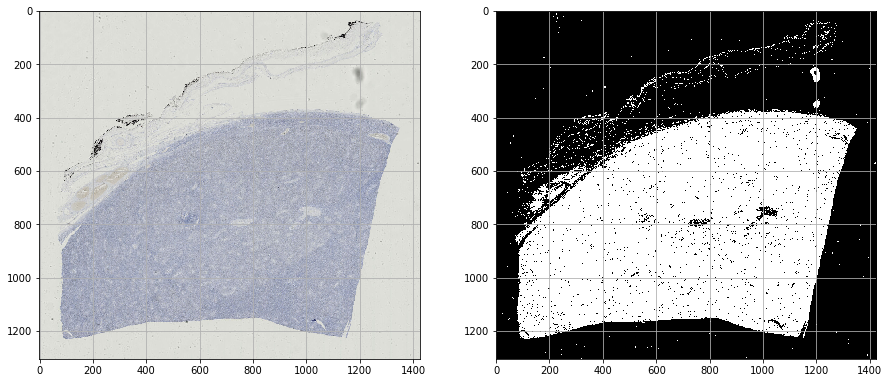

In [8]:
# check foreground segmentation at low-resolution
maxSize = max(ts_metadata['sizeX'], ts_metadata['sizeY'])

fgnd_seg_mag = ts_metadata['magnification'] / 2**np.floor(np.log2(maxSize / 1024))

print fgnd_seg_mag

scale_lres = {'magnification': fgnd_seg_mag}
im_lres, _ = ts.getRegion(
    scale=scale_lres,
    format=large_image.tilesource.TILE_FORMAT_NUMPY,    
)

im_lres = im_lres[:, :, :3]

print im_lres.shape

im_fgnd_mask_lres = htk_utils.simple_mask(im_lres)

plt.subplot(1, 2, 1)
plt.imshow(im_lres)

plt.subplot(1, 2, 2)
plt.imshow(im_fgnd_mask_lres) 

In [12]:
# compute reinhard stats
start_time = time.time()

src_mu_lab, src_sigma_lab = htk_cnorm.reinhard_stats(inputImageFile, 0.01, args.analysis_mag, tissue_seg_mag=0.625)

rstats_time = time.time() - start_time

print('Mean LAB = {}'.format(src_mu_lab))
print('Stddev LAB = {}'.format(src_sigma_lab))
print('Reinhard stats computation time = {} seconds'.format(rstats_time))

Mean LAB = [ 8.94848514e+00 -5.41210587e-02 -8.46866676e-03]
Stddev LAB = [0.35507491 0.08482481 0.01125255]
Reinhard stats computation time = 26.4002299309 seconds


Number of tiles = 1845


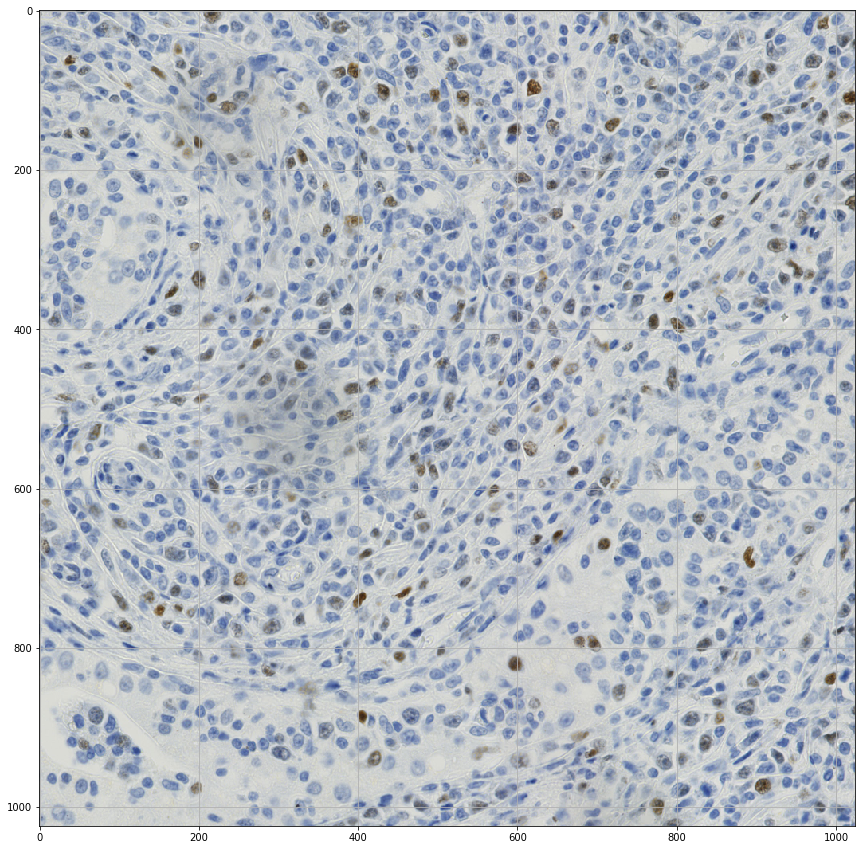

In [12]:
it_kwargs = {
    'tile_size': {'width': args.analysis_tile_size},
    'scale': {'magnification': args.analysis_mag},
    'resample': True
}


num_tiles = ts.getSingleTile(**it_kwargs)['iterator_range']['position']
print('Number of tiles = {}'.format(num_tiles))

tile_position = num_tiles / 2

tile_info = ts.getSingleTile(
    tile_position=tile_position,
    format=large_image.tilesource.TILE_FORMAT_NUMPY,
    **it_kwargs)

im_tile = tile_info['tile'][:, :, :3]

plt.imshow(im_tile)

In [14]:
%lprun -f htk_features.graycomatrixext compute_tile_nuclei_features(inputImageFile, tile_position, args, it_kwargs, src_mu_lab, src_sigma_lab)

In [17]:
%%time 

nuclei_annot_list, fdata = compute_tile_nuclei_features(inputImageFile, tile_position, args, it_kwargs, src_mu_lab, src_sigma_lab, debug=False)

print('Number of nuclei found = {}'.format(len(fdata)))

Number of nuclei found = 1343
CPU times: user 34.9 s, sys: 6.69 s, total: 41.6 s
Wall time: 32.2 s


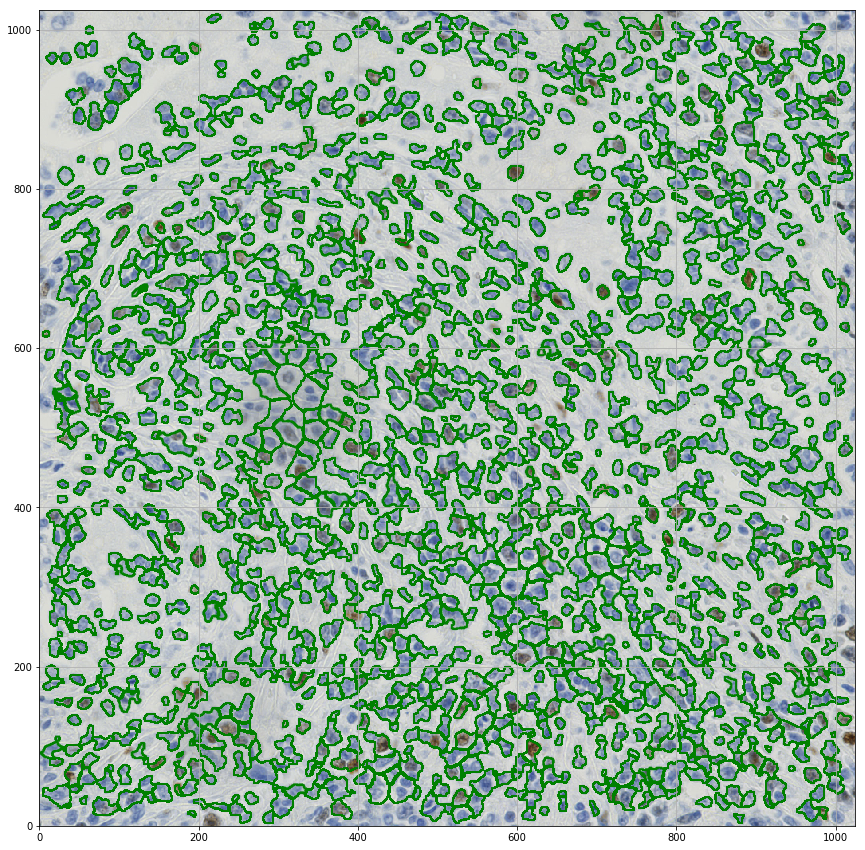

In [18]:
display_tile_nuclei_annotations(im_tile, tile_info, nuclei_annot_list)

### Run on a collection of WSI images

In [19]:
DATA_ROOT_DIR = '/media/nvme/Projects/emory/lymphoma/cmyc'

slide_list = [
    '0023_CMYC_01.svs',    # 2 GB
    '0118_CMYC_01.ndpi',   # 1 GB
    '0038_CMYC_01.svs',    # 2.7 GB
    '0109_CMYC_01.ndpi',   # 819 MB
    '0114_CMYC_01.ndpi',   # 772 MB 
] 

In [20]:
for i in range(len(slide_list)):
    
    print('\n########################################################\n')
    print('Processing slide {}/{} - {}'.format(i+1, len(slide_list), slide_list[i]))
    
    cur_slide_path = os.path.join(DATA_ROOT_DIR, slide_list[i])
    
    compute_slide_nuclei_features(cur_slide_path, args)


########################################################

Processing slide 1/5 - 0023_CMYC_01.svs

>> Reading input image ... 

{
  "magnification": 40.0, 
  "levels": 10, 
  "tileHeight": 240, 
  "tileWidth": 240, 
  "sizeX": 67727, 
  "sizeY": 73738, 
  "mm_y": 0.0002519, 
  "mm_x": 0.0002519
}

>> Computing tissue/foreground mask at low-res ... 



distributed.core - INFO - Event loop was unresponsive in Nanny for 25.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

low-res foreground mask computation time = 0:00:36.100110

>> Computing foreground fraction of all tiles ...

Number of tiles = 1258


tornado.application - ERROR - Exception in callback <bound method BokehTornado._keep_alive of <bokeh.server.tornado.BokehTornado object at 0x7fc9902c4750>>
Traceback (most recent call last):
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/tornado/ioloop.py", line 1229, in _run
    return self.callback()
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/bokeh/server/tornado.py", line 542, in _keep_alive
    c.send_ping()
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/bokeh/server/connection.py", line 80, in send_ping
    self._socket.ping(codecs.encode(str(self._ping_count), "utf-8"))
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/tornado/websocket.py", line 367, in ping
    self.ws_connection.write_ping(data)
  File "/home/deepak.chittajallu/.virtualenvs/emory/local/lib/python2.7/site-packages/tornado/websocket.py", line 882, in write_p

Number of foreground tiles = 531 (42.209857%)
Tile foreground fraction computation time = 0:00:13.804938

>> Computing reinhard color normalization stats ...



distributed.core - INFO - Event loop was unresponsive in Nanny for 1.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.scheduler - INFO - Remove worker tcp://10.171.2.164:43309
distributed.core - INFO - Removing comms to tcp://10.171.2.164:43309
distributed.scheduler - INFO - Remove worker tcp://10.171.2.164:40719
distributed.core - INFO - Removing comms to tcp://10.171.2.164:40719
distributed.scheduler - INFO - Remove worker tcp://10.171.2.164:37407
distributed.core - INFO - Removing comms to tcp://10.171.2.164:37407
distributed.scheduler - INFO - Remove worker tcp://10.171.2.164:39551
distributed.core - INFO - Removing comms to tcp://10.171.2.164:39551
distributed.scheduler - INFO - Remove worker tcp://10.171.2.164:36833
distributed.core - INFO - Removing comms to tcp://10.171.2.164:36833
distributed.scheduler - INFO - Lost all workers
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.worker - INFO -       Start worker at:   tcp://10.171.2.164:34565
distributed.nanny - WARNING - Resta

distributed.scheduler - INFO - Starting worker compute stream, tcp://10.171.2.164:39159
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -       Start worker at:   tcp://10.171.2.164:33133
distributed.core - INFO - Starting established connection
distributed.worker - INFO -          Listening to:   tcp://10.171.2.164:33133
distributed.scheduler - INFO - Register tcp://10.171.2.164:33133
distributed.worker - INFO -              bokeh at:         10.171.2.164:46143
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.171.2.164:33133
distributed.worker - INFO -              nanny at:         10.171.2.164:45623
distributed.worker - INFO - Waiting to connect to:   tcp://10.171.2.164:36017
distributed.core - INFO - Starting established connection
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -               Threads:                          1
distributed.worker 

KeyboardInterrupt: 

distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -       Start worker at:   tcp://10.171.2.164:45735
distributed.worker - INFO -          Listening to:   tcp://10.171.2.164:45735
distributed.worker - INFO -              bokeh at:         10.171.2.164:44753
distributed.worker - INFO -              nanny at:         10.171.2.164:44593
distributed.worker - INFO - Waiting to connect to:   tcp://10.171.2.164:36017
distributed.worker - INFO - -------------------------------------------------
distributed.core - INFO - Starting established connection
distributed.worker - INFO -               Threads:                          1
distributed.worker - INFO -       Local Directory: /home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform/code/IHC-Analysis/BagOfWords/dask-worker-space/worker-s3vkgA
distributed.worker - INFO - -------------------------------------------------
distributed.scheduler - INFO - Register tcp://10.171.2.164:4

distributed.worker - INFO -          Listening to:   tcp://10.171.2.164:36537
distributed.worker - INFO -              bokeh at:         10.171.2.164:40105
distributed.core - INFO - Event loop was unresponsive in Nanny for 1.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.worker - INFO -              nanny at:         10.171.2.164:40929
distributed.core - INFO - Event loop was unresponsive in Nanny for 1.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.worker - INFO - Waiting to connect to:   tcp://10.171.2.164:36017
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -               Threads:                          1
distributed.worker - INFO -       Local Directory: /home/deepak.chittajallu/work/Projects/EmoryImageAnnotationPlatform